In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
from matplotlib import figure
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from random import randrange
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from skorch import NeuralNetBinaryClassifier, NeuralNetRegressor
from skorch.dataset import CVSplit
from skorch.callbacks import Callback

In [2]:
# Settings:
pd.set_option('display.width', 190)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 50)
pd.set_option('max_colwidth', 200)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('default')
np.set_printoptions(threshold = 30, edgeitems = 30, precision = 2, suppress = False)

In [3]:
def split_sequences(Xs, ys, n_steps):
    X, y = list(), list()
    for i in range(len(ys)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(ys):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = Xs[i: end_ix], ys[end_ix - 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y).squeeze()

In [4]:
df_path = "../merged_data/CAPE_BAAFFM_BCI_CCI_CLI_IJC_PMIC_T10Y2Y_T10Y3M_vs_GDP.csv"
features = ['CAPE', "BAAFFM", "BCI", "CCI", "CLI", "IJC", "PMIC", "T10Y2Y", "T10Y3M"]
model_names = ["Linear Regression", "LSTM"]
LSTM_length = 10


In [5]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()

        self.lstm = nn.LSTM(input_size=len(features), hidden_size=LSTM_length, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.dense = nn.Linear(LSTM_length, 1)

    def forward(self, X, **kwargs):
        output, hidden = self.lstm(X)
        X = self.dense(self.dropout(output[:, -1, :]))
        return X

    
class FixRandomSeed(Callback):
    
    def __init__(self, seed=1):
        self.seed = seed
    
    def initialize(self):
        print("setting random seed to: ",self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        
        try:
            random.seed(self.seed)
        except NameError:
            import random
            random.seed(self.seed)

        np.random.seed(self.seed)
        torch.backends.cudnn.deterministic=True
        
def get_LSTM_model():
    model = NeuralNetRegressor(
        MyModule,
        optimizer=Adam,
        max_epochs=10,
        lr=1e-3,
        batch_size=64,
        iterator_train__shuffle=True,
        verbose=0,
        callbacks=[FixRandomSeed()]
    )
    return model

In [6]:
get_models = [lambda: linear_model.LinearRegression(), lambda: get_LSTM_model()]
target_variable = "GDP_rate"

In [7]:
# Read the data and do a little bit of wrangling:
df = pd.read_csv(df_path)
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date", drop=True)
df = df.dropna()


In [8]:
# Split into training and test sets and hold out the test set until the end, so that it remains "unseen".
lag_of_y = 180 # This is the lag in days we introduce to the predictor variable so that we assess 
              # the indicator's ability to predict the target variable this many steps into the future.

df_x = df.iloc[:-lag_of_y][features]
df_y = df.iloc[lag_of_y:][target_variable]
        
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, shuffle=False)


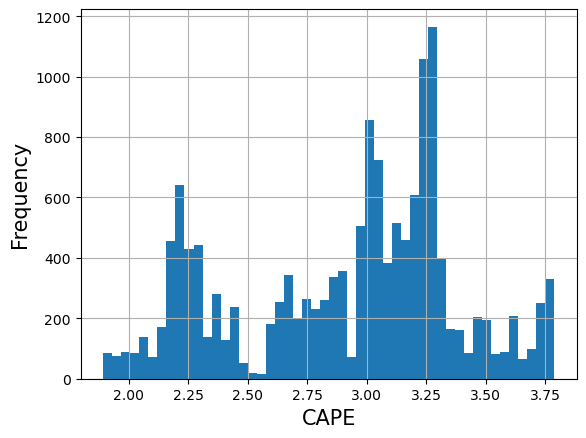

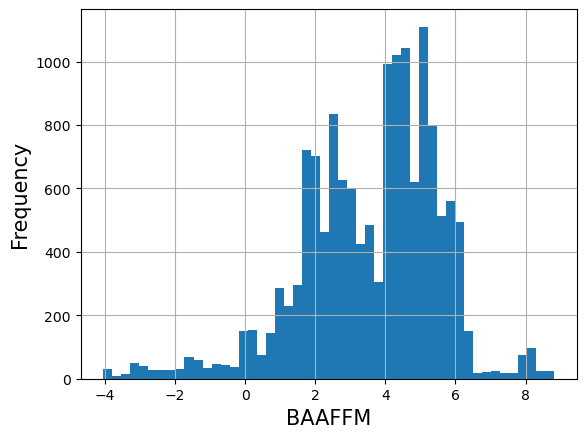

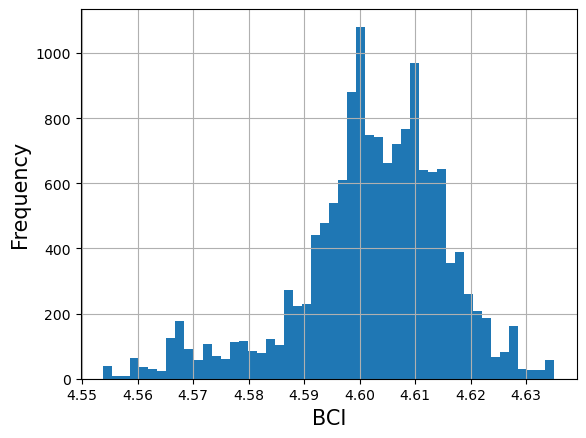

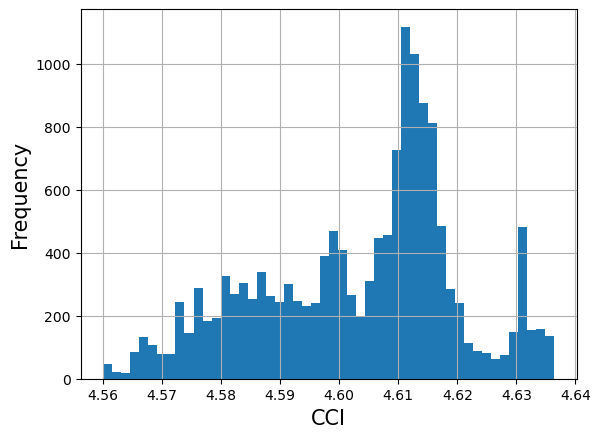

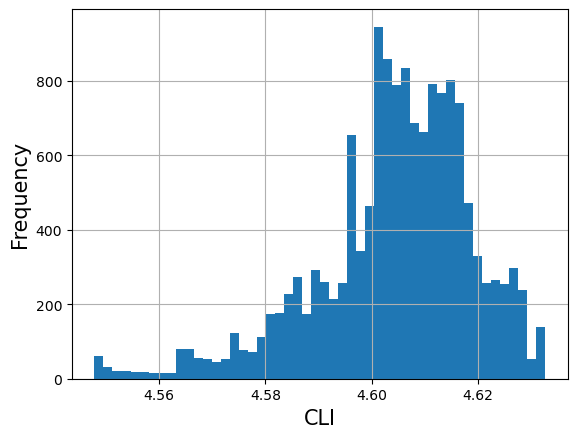

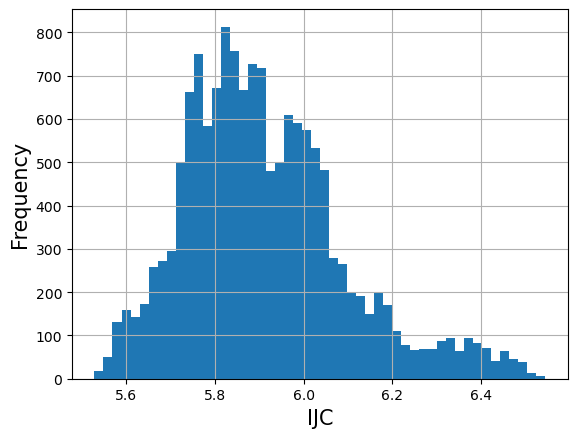

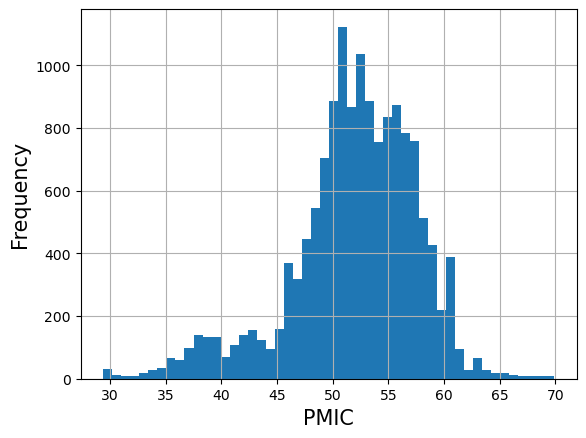

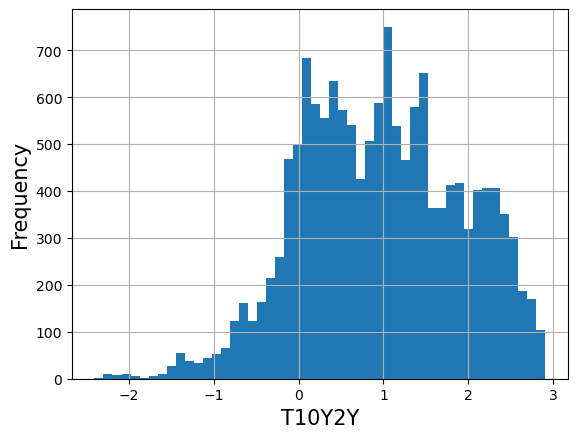

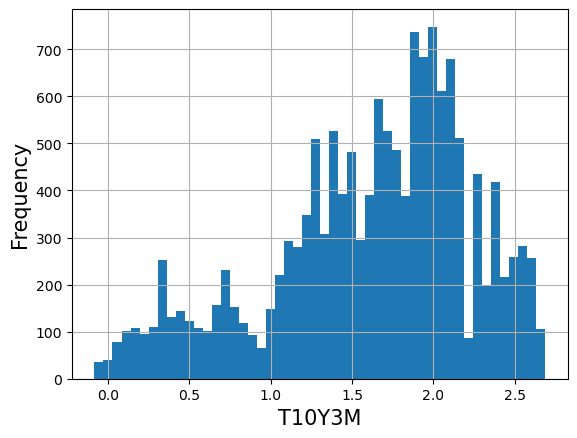

In [9]:
# Histrograms of the features in training set before any scaling
for feature in features:
    plt.figure()
    X_train[feature].hist(bins = 50)
    plt.xlabel(feature,fontsize=15)
    plt.ylabel("Frequency",fontsize=15)
    plt.show()


 ## Validation

In [10]:
# Do a time series cross-validation on the test set by splitting it into k folds and doing a "rolling"
# validation against a validation fold, then averaging out the metrics.
splits = 3 # This is the number of splits/folds in the rolling validation.
tscv = TimeSeriesSplit(n_splits=splits)
pd.options.mode.chained_assignment = None

AUC_ROCs = dict()
ACCs = dict()


In [11]:
## Regression
R2s = dict()
print(target_variable)
for model_name, get_model in zip(model_names, get_models):
    print()
    print(model_name)
    R2s[model_name] = 0
    for train_index, test_index in tscv.split(X_train): # Rolling cross-validation happens inside this loop.
        X_train_fold, X_validation_fold = X_train.iloc[train_index,][features], X_train.iloc[test_index,][features]
        y_train_fold, y_validation_fold = y_train.iloc[train_index,], y_train.iloc[test_index,]

        scalers = dict()
        for feature in features:
            scalers[feature] = StandardScaler()
            scalers[feature].fit(X_train_fold[[feature]])
            X_train_fold[feature] = scalers[feature].transform(X_train_fold[[feature]])
            X_validation_fold[feature] = scalers[feature].transform(X_validation_fold[[feature]])

        if model_name == 'LSTM':
            X_train_fold_original = X_train_fold.copy()
            y_train_fold_original = y_train_fold.copy()
            X_train_fold, y_train_fold = split_sequences(X_train_fold.to_numpy(), y_train_fold.to_numpy(), n_steps=LSTM_length)
            X_train_fold = X_train_fold.astype(np.float32)
            y_train_fold = y_train_fold.astype(np.float32)
            X_validation_fold = pd.concat([X_train_fold_original.iloc[-LSTM_length+1:], X_validation_fold])
            y_validation_fold = pd.concat([y_train_fold_original.iloc[-LSTM_length+1:], y_validation_fold])
            X_validation_fold, y_validation_fold = split_sequences(X_validation_fold.to_numpy(), y_validation_fold.to_numpy(), n_steps=LSTM_length)
            X_validation_fold = X_validation_fold.astype(np.float32)
            y_validation_fold = y_validation_fold.astype(np.float32)

        model = get_model()
        if model_name != 'LSTM':
            model.fit(X_train_fold[features], y_train_fold)
            predictions = model.predict(X_validation_fold[features])
            R2 = r2_score(y_validation_fold, predictions)
        else:
            model.fit(X_train_fold, y_train_fold.reshape(-1, 1))
            predictions = model.predict(X_validation_fold)
            R2 = r2_score(y_validation_fold, predictions)
        R2s[model_name] += R2
        print(R2)

    R2s[model_name] /= splits
for model_name in model_names:
    print(model_name)
    print(f"Average R2 score: {R2s[model_name]}")


GDP_rate

Linear Regression
-2.0167198638636172
-0.5468158774922267
-1.9772783444844686

LSTM
setting random seed to:  1
-0.6100015323199199
setting random seed to:  1
-0.32631195981775885
setting random seed to:  1
-0.4526790503658087
Linear Regression
Average R2 score: -1.5136046952801043
LSTM
Average R2 score: -0.46299751416782914


 ## Test

In [12]:
y_test.value_counts()


1.9000    4
2.2913    2
2.3000    2
2.6826    2
3.1297    2
2.8087    2
2.8217    2
2.8348    2
2.7804    2
2.8478    2
2.8609    2
1.6500    2
2.8130    2
2.8739    2
3.1824    2
2.9000    2
1.9500    2
2.8783    2
1.9167    2
2.9391    2
2.9783    2
3.0174    2
3.0087    2
3.0565    2
1.4000    2
         ..
3.3044    1
3.3703    1
3.3736    1
3.3769    1
3.3802    1
3.1880    1
3.2043    1
3.2207    1
3.2370    1
3.2533    1
3.2696    1
3.2859    1
3.3022    1
3.3185    1
3.3348    1
3.3511    1
3.3674    1
3.3837    1
3.4000    1
3.3967    1
3.3934    1
3.3901    1
3.3868    1
3.3835    1
6.7000    1
Name: GDP_rate, Length: 1580, dtype: int64

In [13]:
X_train = X_train.copy()
X_test = X_test.copy()

all_scalers = dict()
for feature in features:
    all_scalers[feature] = StandardScaler()
    all_scalers[feature].fit(X_train[[feature]]) # Do z-score scaling on the training set/split...
    X_train[feature] = all_scalers[feature].transform(X_train[[feature]])
    X_test[feature] = all_scalers[feature].transform(X_test[[feature]]) # ...and use the same
    # scaling parameters to transform the test set/split to the same scale with it (to avoid data leakage)


In [14]:
for feature in features:
    print(all_scalers[feature].mean_)


[2.92]
[3.59]
[4.6]
[4.6]
[4.6]
[5.91]
[51.92]
[0.97]
[1.61]


In [15]:
## Regression
print(target_variable)
for model_name, get_model in zip(model_names, get_models):
    print()
    print(model_name)

    if model_name == 'LSTM':
        current_X_train, current_y_train = split_sequences(X_train[features].to_numpy(), y_train.to_numpy(), n_steps=LSTM_length)
        current_X_train = current_X_train.astype(np.float32)
        current_y_train = current_y_train.astype(np.float32)
        current_X_test = pd.concat([X_train.iloc[-LSTM_length+1:], X_test])
        current_y_test = pd.concat([y_train.iloc[-LSTM_length+1:], y_test])
        current_X_test, current_y_test = split_sequences(current_X_test[features].to_numpy(), current_y_test.to_numpy(), n_steps=LSTM_length)
        current_X_test = current_X_test.astype(np.float32)
        current_y_test = current_y_test.astype(np.float32)

    model = get_model()
    if model_name != 'LSTM':
        model.fit(X_train[features], y_train)
        predictions = model.predict(X_test[features])
        R2 = r2_score(y_test, predictions)
    else:
        model.fit(current_X_train, current_y_train.reshape(-1, 1))
        predictions = model.predict(current_X_test)
        R2 = r2_score(current_y_test, predictions)
    print("Test R2:", R2)

mean_value = y_train.mean()
print("\nBaseline #1: Always predicting the average value\nR2:",
     r2_score(y_test, np.full(len(y_test), mean_value)))

last_value = y_train[-1]
print("\nBaseline #2: Always predicting the last value\nR2:",
     r2_score(y_test, np.full(len(y_test), last_value)))
    

GDP_rate

Linear Regression
Test R2: 0.349696727411657

LSTM
setting random seed to:  1
Test R2: -0.06655677783859715

Baseline #1: Always predicting the average value
R2: -0.0021854151166593727

Baseline #2: Always predicting the last value
R2: -0.0025956599183247775


## Final predictions

In [16]:
extended_dates = df.iloc[-lag_of_y:].index.shift(lag_of_y, freq="d").tolist()
pickle.dump(extended_dates, open('../predictions/GDP_extended_dates.pkl', 'wb'))
df_test = df.iloc[-lag_of_y:][features]

In [17]:
print(target_variable)
for model_name, get_model in zip(model_names, get_models):
    print()
    print(model_name)
    model = get_model()
    if model_name != 'LSTM':
        model.fit(df_x[features], df_y)
        predictions = model.predict(df_test[features])
    else:
        current_X_train, current_y_train = split_sequences(df_x[features].to_numpy(), df_y.to_numpy(), n_steps=LSTM_length)
        current_X_train = current_X_train.astype(np.float32)
        current_y_train = current_y_train.astype(np.float32)
        model.fit(current_X_train, current_y_train.reshape(-1, 1))
        current_df_test = df.iloc[-lag_of_y-LSTM_length+1:][features]
        current_df_test = current_df_test.astype(np.float32)
        current_df_test, _ = split_sequences(current_df_test.to_numpy(), np.ones(len(current_df_test)), n_steps=LSTM_length)
        current_X_train = current_X_train.astype(np.float32)
        predictions = model.predict(current_df_test)
    pickle.dump(predictions, open('../predictions/' + model_name + '_' + target_variable + '.pkl', 'wb'))


GDP_rate

Linear Regression

LSTM
setting random seed to:  1
